In [1]:
import sys 
sys.path.append('ramp/')
from tqdm import tqdm 

import pandas as pd 
import numpy as np

from ramp import get_prices as gp 
from ramp import utils as ut 
from ramp import plot as plot
from ramp import get_data as gd  
from ramp import config as cf 



## Table of Contents

- [I - Exploratory Data Analysis (EDA)](#i---exploratory-data-analysis-eda)
  - [1. Analysis of Stock Volume in the NIFTY 100 Index](#1-analysis-of-stock-volume-in-the-nifty-100-index)
    - [Objectives](#objectives)
    - [Observations on Initial Trading Dates](#observations-on-initial-trading-dates)
  - [2) Assessment of Data Frequency](#2-assessment-of-data-frequency)
    - [Trading Hours Analysis](#trading-hours-analysis)
    - [Weekday Analysis](#weekday-analysis)
    - [Feature Volatility Assessment](#feature-volatility-assessment)
  - [3) Assessment of Stock Correlation within the Selected Universe](#3-assessment-of-stock-correlation-within-the-selected-universe)
    - [Correlation Matrix Analysis](#correlation-matrix-analysis)
    - [Market Proxy Identification](#market-proxy-identification)


# I - Exploratory Data Analysis (EDA)

## 1. Analysis of Stock Volume in the NIFTY 100 Index 

In this section, we conduct a comprehensive exploratory data analysis focusing on the stock volumes within the NIFTY 100 Index. The NIFTY 100 represents the top 100 companies listed on the National Stock Exchange of India (NSE), providing a broad indicator of the Indian equity market performance.


### Objectives:


- **Aggregate Total Traded Volume**: Calculate the total traded volume for each stock across different semesters from 2015 to 2021.

- **Identify New Market Entrants**: Recognize stocks that entered the market post-2015 and analyze their impact on trading volumes.

- **Quantile Classification**: Utilize quantiles to classify stocks based on their trading volumes, helping to identify top performers.

- **Visualization**: Create visual representations of volume distributions to uncover patterns and trends over time.

- **Top Stocks Identification**: Highlight stocks in the top quantile of trading volumes for each semester.

In [2]:
# Initialize an empty list to store the results
first_volume_dates = []

# Iterate through each stock in the available stocks list
for stock in tqdm(cf.available_stocks, total=len(cf.available_stocks)):
    df_stock = gp.get_prices(stock)
    # Ensure the index is datetime type
    df_stock.index = pd.to_datetime(df_stock.index)
    
    # Filter the DataFrame to find rows where 'volume' is not null and greater than zero
    non_null_volume = df_stock[df_stock['volume'].notna() & (df_stock['volume'] > 0)]
    
    if not non_null_volume.empty:
        # Get the first date where volume is not null
        first_date = non_null_volume.index.min()
        # Append the stock name and first date to the list
        first_volume_dates.append({'stock': stock, 'date': first_date})
    else:
        # Handle stocks with all zero or null volumes
        first_volume_dates.append({'stock': stock, 'date': None})

# Create a DataFrame from the list
first_volume_dates_df = pd.DataFrame(first_volume_dates)

# Group the DataFrame by 'First_NonNull_Volume_Date' and count the number of stocks for each date
date_counts_series = first_volume_dates_df.groupby('date')['stock'].count()

# Convert the Series to a dictionary
date_counts = date_counts_series.to_dict()

# Display the resulting dictionary
print("Number of stocks for each first non-null volume date:")
for date, count in date_counts.items():
    print(f"{date}: {count} stocks")

100%|██████████| 99/99 [00:21<00:00,  4.64it/s]

Number of stocks for each first non-null volume date:
2015-02-02 09:00:00: 87 stocks
2015-11-10 09:25:00: 1 stocks
2016-07-21 09:25:00: 1 stocks
2016-09-29 09:25:00: 1 stocks
2017-03-21 09:25:00: 1 stocks
2017-09-27 09:25:00: 1 stocks
2017-10-03 09:25:00: 1 stocks
2017-11-17 09:25:00: 1 stocks
2018-03-27 09:25:00: 1 stocks
2018-06-18 09:25:00: 1 stocks
2018-08-06 09:25:00: 1 stocks
2020-03-16 09:20:00: 1 stocks
2020-11-20 09:25:00: 1 stocks


**Observations on Initial Trading Dates**

An analysis of the first non-null volume dates for each stock reveals that the majority began reporting trading volumes on **February 2, 2015**. This suggests a common starting point for data availability . However, a subset of stocks entered the market progressively over the subsequent years, with new entrants observed periodically until as recently as **November 20, 2020**. These later entries indicate ongoing additions to the market, reflecting the dynamic nature of stock listings over the examined period.

In [2]:
# Get total volume for each stock for each semester
volumes = []
for stock in tqdm(cf.available_stocks, total=len(cf.available_stocks)):
    dfi = gp.get_prices(stock)
    dfi['semester'] = ut.get_group_key('semester',dfi)
    dfi['volume_quoted_dollars'] = dfi['volume'] * dfi['close']
    # Group by semester and sum 'VoV'
    volume_sum_df = dfi.groupby('semester', as_index=False)['volume_quoted_dollars'].sum()
    volume_sum_df['stock'] = stock 
    volume_sum_df = volume_sum_df[['stock','semester','volume_quoted_dollars']]
    volume_sum_df.columns = ['stock','semester','total_volume']
    volumes.append(volume_sum_df)

# Concatenate all stocks' data
volumes_sum_df = pd.concat(volumes, ignore_index=True)

pd.set_option('display.float_format', '{:,.2f}'.format)

print('Sample of the volumes_sum_df dataframe:')
print(volumes_sum_df.head())

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [00:48<00:00,  2.03it/s]

Sample of the volumes_sum_df dataframe:
  stock semester       total_volume
0   ACC  S1-2015  57,465,203,570.25
1   ACC  S1-2016  45,579,182,803.45
2   ACC  S1-2017  67,121,060,162.35
3   ACC  S1-2018  75,244,085,864.15
4   ACC  S1-2019 142,994,996,428.00


In [3]:
semesters = volumes_sum_df['semester'].unique()
n_quantiles = 5  # Define number of quantiles
semester_to_quantile_distribution = {}

# Create a figure for each semester
for semester in semesters:
    # Filter data for this semester
    semester_data = volumes_sum_df[volumes_sum_df['semester'] == semester]
    
    # Create series of volumes for this semester
    volume_series = semester_data.set_index('stock')['total_volume']
    
    # Plot histogram with quantiles
    fig = plot.plot_histogram_quantile(
        series=volume_series,
        n_quantiles=n_quantiles,
        title=f'Volume Distribution for {semester}'
    )
    
    # Calculate quantile boundaries
    quantile_values = np.linspace(0, 100, n_quantiles + 1)
    quantiles = np.percentile(volume_series, quantile_values)
    
    # Create dictionary for this semester
    stock_to_quantile = {}
    for stock, volume in volume_series.items():
        # Find which quantile the volume belongs to
        quantile_index = np.digitize(volume, quantiles) - 1
        stock_to_quantile[stock] = quantile_index
    
    # Store in main dictionary
    semester_to_quantile_distribution[semester] = stock_to_quantile
    
    # Show the plot
    fig.show()

In [6]:
def get_probability_quantile(group_key_to_quantile_distribution):
    """
    Calculate probability distribution of quantiles for each stock across all periods.
    
    Args:
        group_key_to_quantile_distribution: Dictionary with structure {semester: {stock: quantile}}
    
    Returns:
        DataFrame with stocks as index and quantile probabilities as columns
    """
    # Get all unique stocks and quantiles across all periods
    all_stocks = set()
    all_quantiles = set()
    for quantile_distribution in group_key_to_quantile_distribution.values():
        all_stocks.update(quantile_distribution.keys())
        all_quantiles.update(quantile_distribution.values())
    
    n_quantiles = max(all_quantiles) + 1  # Add 1 because quantiles are 0-based
    
    # Initialize dictionary to store quantile counts for each stock
    stock_quantile_counts = {
        stock: {i: 0 for i in range(n_quantiles)} 
        for stock in all_stocks
    }
    stock_total_periods = {stock: 0 for stock in all_stocks}
    
    # Count occurrences of each quantile for each stock
    for period_distribution in group_key_to_quantile_distribution.values():
        for stock, quantile in period_distribution.items():
            stock_quantile_counts[stock][quantile] += 1
            stock_total_periods[stock] += 1
    
    # Calculate probabilities
    probabilities = {}
    for stock in all_stocks:
        total_periods = stock_total_periods[stock]
        if total_periods > 0:  # Avoid division by zero
            probabilities[stock] = {
                f'Q{i}': stock_quantile_counts[stock][i] / total_periods 
                for i in range(n_quantiles)
            }
    
    # Convert to DataFrame
    prob_df = pd.DataFrame.from_dict(probabilities, orient='index')
    
    return prob_df

# Example usage:
quantile_probabilities = get_probability_quantile(semester_to_quantile_distribution)
quantile_probabilities = quantile_probabilities.sort_values(by='Q5',ascending=True)
print("\nProbability Distribution of Quantiles per Stock:")
print(quantile_probabilities)


Probability Distribution of Quantiles per Stock:
             Q0   Q1   Q2   Q3   Q4   Q5
NAUKRI     0.73 0.07 0.07 0.13 0.00 0.00
INFY       0.00 0.00 0.00 0.00 1.00 0.00
BERGEPAINT 0.93 0.07 0.00 0.00 0.00 0.00
ONGC       0.00 0.07 0.33 0.60 0.00 0.00
PGHH       1.00 0.00 0.00 0.00 0.00 0.00
...         ...  ...  ...  ...  ...  ...
TCS        0.00 0.00 0.00 0.00 0.93 0.07
YESBANK    0.00 0.20 0.07 0.07 0.60 0.07
SBIN       0.00 0.00 0.00 0.00 0.93 0.07
AXISBANK   0.00 0.00 0.00 0.00 0.87 0.13
RELIANCE   0.00 0.00 0.00 0.00 0.47 0.53

[99 rows x 6 columns]


In [7]:
plot.create_heatmap(quantile_probabilities,x_title='Quantile',y_title='Stocks')

This plot illustrates the probability distribution of each stock being in a given quantile across all semesters. We observe that certain stocks remain consistently within the same quantile, indicating stability over time, whereas others exhibit volatility by moving between quantiles. Our objective is to select stocks that are stable within the top quantiles.

Given the histogram, we focus on stocks in quantiles Q5, Q4, and Q3. However, it is also important to study the stability of these stocks. Specifically, we need to determine if there is a high probability for stocks to remain in Q5, Q4, or Q3 across semesters.

In [8]:
def get_quantile_stability(semester_to_quantile_distribution):
    """
    Calculate transition probability matrix between quantiles across consecutive semesters.
    
    Args:
        semester_to_quantile_distribution (dict): Dictionary with structure 
            {semester: {stock: quantile}}
    
    Returns:
        pd.DataFrame: Transition probability matrix where rows and columns are quantiles
            Cell[i,j] represents P(Next Quantile = j | Current Quantile = i)
    """
    # First, let's identify all unique quantiles in the data
    all_quantiles = set()
    for semester_data in semester_to_quantile_distribution.values():
        all_quantiles.update(set(semester_data.values()))
    
    # Initialize transition counts matrix using actual quantiles
    transition_counts = {
        q: {j: 0 for j in all_quantiles} 
        for q in all_quantiles
    }
    
    # Initialize total counts for each starting quantile
    quantile_totals = {q: 0 for q in all_quantiles}
    
    # Get ordered semesters
    semesters = sorted(semester_to_quantile_distribution.keys())
    
    # For each consecutive pair of semesters
    for i in range(len(semesters) - 1):
        current_semester = semester_to_quantile_distribution[semesters[i]]
        next_semester = semester_to_quantile_distribution[semesters[i + 1]]
        
        # For each stock present in both semesters
        common_stocks = set(current_semester.keys()) & set(next_semester.keys())
        for stock in common_stocks:
            current_quantile = current_semester[stock]
            next_quantile = next_semester[stock]
            
            # Update transition counts
            transition_counts[current_quantile][next_quantile] += 1
            quantile_totals[current_quantile] += 1
    
    # Calculate probabilities
    prob_matrix = {}
    for start_quantile in all_quantiles:
        if quantile_totals[start_quantile] > 0:
            prob_matrix[f'Q{start_quantile}'] = {
                f'Q{end_quantile}': transition_counts[start_quantile][end_quantile] / quantile_totals[start_quantile]
                for end_quantile in all_quantiles
            }
        else:
            prob_matrix[f'Q{start_quantile}'] = {
                f'Q{end_quantile}': 0 
                for end_quantile in all_quantiles
            }
    
    # Convert to DataFrame
    prob_df = pd.DataFrame.from_dict(prob_matrix, orient='index')
    
    # Sort index and columns to ensure consistent ordering
    prob_df.sort_index(inplace=True)
    prob_df = prob_df[sorted(prob_df.columns)]
    
    return prob_df

 

transition_probs = get_quantile_stability(semester_to_quantile_distribution)
print('Transition probabilities between quantiles:')
print(transition_probs)

Transition probabilities between quantiles:
     Q0   Q1   Q2   Q3   Q4   Q5
Q0 0.65 0.23 0.09 0.02 0.01 0.00
Q1 0.25 0.42 0.23 0.07 0.03 0.00
Q2 0.05 0.26 0.38 0.26 0.04 0.00
Q3 0.02 0.07 0.26 0.50 0.15 0.00
Q4 0.00 0.00 0.04 0.16 0.75 0.04
Q5 0.00 0.00 0.07 0.00 0.64 0.29


In [9]:
plot.create_heatmap(transition_probs,x_title='Quantile',y_title='Quantile')

This plot highlights:

1. When a stock is in **Q5**, it has a high probability to stay in **Q5** or to move to **Q4**.

2. When a stock is in **Q4**, it has a high probability to stay in **Q4** or to move to **Q3** or **Q5**.

3. When a stock is in **Q3**, it has a high probability to stay in **Q3** or to move to **Q4**.

So because there is a low probability to move to a lower quantile when a stock is in a high quantile, we can say that picking stocks that are in the top quantiles makes sense.

In [10]:
def pick_quantiles(quantile_probabilities, target_quantiles):
    """
    Select stocks based on their highest probability quantiles.
    
    Args:
        quantile_probabilities (DataFrame): DataFrame with stocks as index and quantile probabilities as columns
        target_quantiles (list): List of quantiles to filter for (e.g., ['Q4', 'Q5'])
    
    Returns:
        list: List of stocks whose highest probability quantile is in target_quantiles
    """
    # Create dictionary to store stock: highest_probability_quantile pairs
    stock_highest_quantile = {}
    
    # For each stock
    for stock in quantile_probabilities.index:
        # Get probabilities for this stock
        probs = quantile_probabilities.loc[stock]
        # Find the quantile with highest probability
        highest_prob_quantile = probs.idxmax()
        # Store in dictionary
        stock_highest_quantile[stock] = highest_prob_quantile
    
    # Filter stocks based on target quantiles
    selected_stocks = [
        stock for stock, quantile in stock_highest_quantile.items() 
        if quantile in target_quantiles
    ]
    
    return selected_stocks 
# Select stocks most likely to be in top two quantiles
selected_stocks = pick_quantiles(quantile_probabilities, ['Q4', 'Q5','Q3'])
selected_stocks = sorted(selected_stocks)
print(f'selected_stocks: {selected_stocks}')
print(f'There are {len(selected_stocks)} stocks in the selected list')

selected_stocks: ['ADANIPORTS', 'ASIANPAINT', 'AUROPHARMA', 'AXISBANK', 'BAJFINANCE', 'BANKBARODA', 'BHARTIARTL', 'BPCL', 'DLF', 'DRREDDY', 'HDFC', 'HDFCBANK', 'HEROMOTOCO', 'HINDALCO', 'HINDPETRO', 'HINDUNILVR', 'ICICIBANK', 'INDUSINDBK', 'INFY', 'IOC', 'ITC', 'JINDALSTEL', 'KOTAKBANK', 'LT', 'LUPIN', 'MARUTI', 'M_M', 'ONGC', 'RELIANCE', 'SBIN', 'SUNPHARMA', 'TATAMOTORS', 'TATASTEEL', 'TCS', 'TECHM', 'TITAN', 'ULTRACEMCO', 'VEDL', 'YESBANK']
There are 39 stocks in the selected list


### 2) Assessment of Data Frequency

The dataset at our disposal comprises extensive records, with each feature sampled every five minutes. Recognizing that financial markets do not operate continuously throughout the day, it is imperative to ascertain the specific opening and closing times of the market under study. This understanding will enable us to evaluate whether aggregating the data to a lower temporal frequency is appropriate or whether the characteristics of the data necessitate the development of an intraday trading strategy.

In [11]:
# Initialize a list to store all interval counts
all_interval_counts = []

for stock in tqdm(cf.top_nifty, total=len(cf.top_nifty)):
    df = gp.get_prices(stock)
    df['day'] = ut.get_group_key('day', df)
    date_to_number_traded_5min = df.groupby('day').size()
    
    # Get value counts and convert to DataFrame
    interval_distribution = date_to_number_traded_5min.value_counts()
    all_interval_counts.append(interval_distribution)

# Combine all counts
combined_df = pd.concat(all_interval_counts, axis=1)

# Calculate mean only for non-null values
mean_counts = combined_df.apply(lambda x: x[x.notna()].mean(), axis=1)

# Create final DataFrame
result_df = pd.DataFrame({
    'value': mean_counts.index,
    'count': mean_counts.values
}).sort_values('value')

print("Average nnumber of 5-minute intervals per day across all stocks:")
print(result_df.reset_index(drop=True))

100%|██████████| 39/39 [00:10<00:00,  3.86it/s]

Average nnumber of 5-minute intervals per day across all stocks:
    value    count
0      12     7.00
1      14     1.00
2      36     1.00
3      45     1.00
4      64     2.00
5      71     1.46
6      72     1.00
7      73     1.03
8      74     1.00
9      75 1,730.23
10     76     1.00


The analysis indicates that most trading days consist of 75 × 5 = 375 trading minutes, based on 75 intervals of 5 minutes each. This corresponds to an average of 375/60 = 6.25 hours of trading per day. Notably, there are some outlier days that deviate from this pattern, which will be addressed in subsequent sections. It is therefore essential to identify the precise opening and closing times of the market to fully comprehend these discrepancies.

In [12]:
# Initialize dictionaries to store timestamps
first_timestamps = {}
last_timestamps = {}

for stock in tqdm(cf.top_nifty, total=len(cf.top_nifty)):
    df = gp.get_prices(stock)
    df['day'] = ut.get_group_key('day', df)
    df['date'] = [x for x in df.index]
    df = df[['day','date']].copy(deep=True)
    
    # Group by day and get first/last timestamps
    daily_timestamps = df.groupby('day').agg({
        'date': ['first', 'last']
    })
    
    # Add timestamps to dictionaries
    for day, (first, last) in daily_timestamps.iterrows():
        # Convert timestamps to time only (removing date)
        first_time = pd.Timestamp(first).time()
        last_time = pd.Timestamp(last).time()
        
        # Update first timestamps count
        if first_time not in first_timestamps:
            first_timestamps[first_time] = 0
        first_timestamps[first_time] += 1
        
        # Update last timestamps count
        if last_time not in last_timestamps:
            last_timestamps[last_time] = 0
        last_timestamps[last_time] += 1

# Convert to DataFrames and sort by count
first_df = pd.DataFrame.from_dict(first_timestamps, orient='index', columns=['count']).sort_values('count', ascending=False)
last_df = pd.DataFrame.from_dict(last_timestamps, orient='index', columns=['count']).sort_values('count', ascending=False)

print("Most common first timestamps:")
print(first_df)
print("\nMost common last timestamps:")
print(last_df)

100%|██████████| 39/39 [00:20<00:00,  1.88it/s]

Most common first timestamps:
          count
03:45:00  67704
12:45:00    117
13:00:00     78
09:00:00     39
04:05:00     39
12:05:00     39
07:00:00     39
12:00:00     39

Most common last timestamps:
          count
09:55:00  67762
13:40:00    117
13:55:00     78
13:15:00     39
12:55:00     39
11:25:00     39
10:00:00     20


Our analysis indicates that the majority of trading days commence at **03:45:00** and conclude at **09:55:00**.

To address the anomalous trading days, we will select a stock with an extensive historical record and examine the distribution of trading days in detail.

In [13]:
def analyze_weekdays(df):
    df['day'] = ut.get_group_key('day',df)
    df = df.groupby('day').mean()
    df.index = pd.to_datetime(df.index)
    # Create dictionary for weekdays
    weekdays = {
        'Monday': {'count': 0, 'dates': []},
        'Tuesday': {'count': 0, 'dates': []},
        'Wednesday': {'count': 0, 'dates': []},
        'Thursday': {'count': 0, 'dates': []},
        'Friday': {'count': 0, 'dates': []},
        'Saturday': {'count': 0, 'dates': []},
        'Sunday': {'count': 0, 'dates': []}
    }
    
    # Map weekday numbers to names
    day_map = {
        0: 'Monday',
        1: 'Tuesday',
        2: 'Wednesday',
        3: 'Thursday',
        4: 'Friday',
        5: 'Saturday',
        6: 'Sunday'
    }
    
    # Iterate through the data using the datetime index
    for date in df.index:
        # Get weekday number (0 = Monday, 6 = Sunday)
        weekday_num = date.weekday()
        weekday_name = day_map[weekday_num]
        
        # Update count and store the date
        weekdays[weekday_name]['count'] += 1
        weekdays[weekday_name]['dates'].append(date.strftime('%Y-%m-%d'))
    
    return weekdays

# Example usage for Reliance data:
weekday_analysis = analyze_weekdays(gp.get_prices('PNB'))

# Print results
for day, data in weekday_analysis.items():
    print(f"\n{day}:")
    print(f"Number of occurrences: {data['count']}")


Monday:
Number of occurrences: 347

Tuesday:
Number of occurrences: 350

Wednesday:
Number of occurrences: 354

Thursday:
Number of occurrences: 350

Friday:
Number of occurrences: 340

Saturday:
Number of occurrences: 3

Sunday:
Number of occurrences: 2


Typically, the Indian stock market operates from Monday to Friday. However, on some Saturdays and Sundays, the market remains open to allow market participants to digest volatility arising from budget announcements.

We also observed that on certain Mondays, Tuesdays, Thursdays, and Fridays, the market was closed, likely due to public holidays.

100%|██████████| 39/39 [01:15<00:00,  1.94s/it]


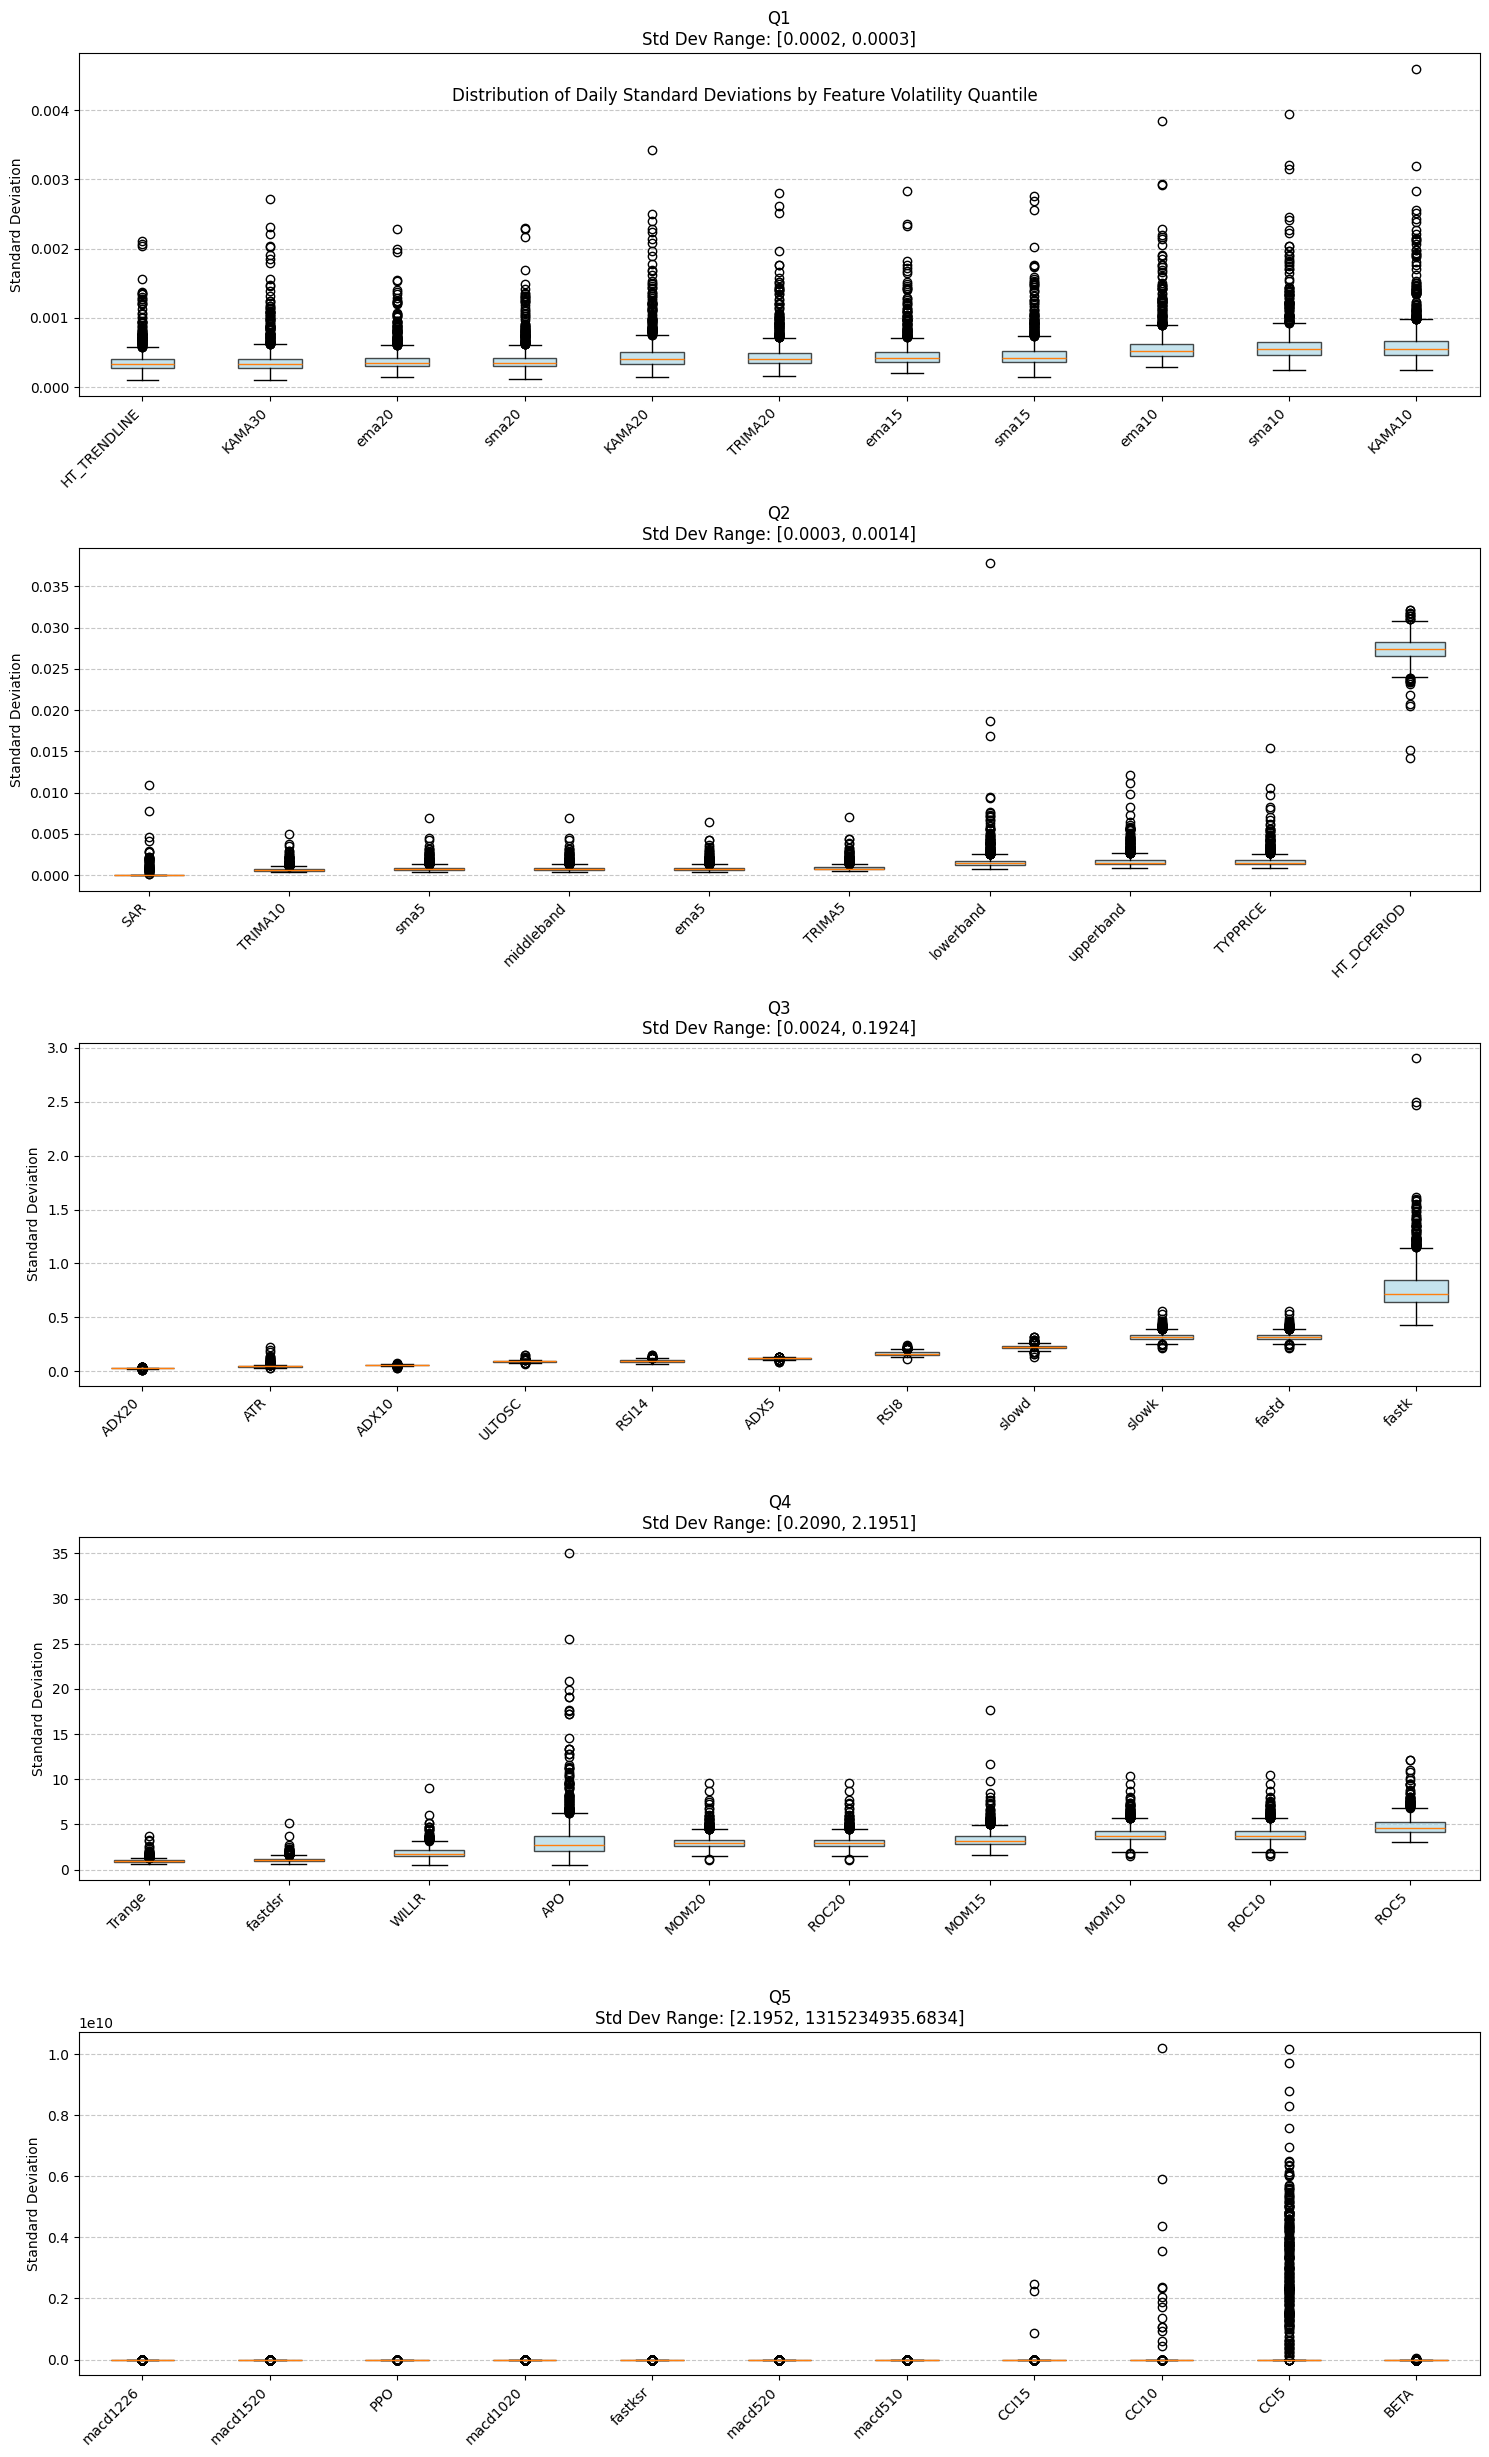


Features by volatility quantile:

Q1 features:
  sma10: 0.0003
  sma15: 0.0002
  sma20: 0.0002
  ema10: 0.0002
  ema15: 0.0002
  ema20: 0.0002
  HT_TRENDLINE: 0.0002
  KAMA10: 0.0003
  KAMA20: 0.0002
  KAMA30: 0.0002
  TRIMA20: 0.0002

Q2 features:
  sma5: 0.0004
  ema5: 0.0004
  upperband: 0.0008
  middleband: 0.0004
  lowerband: 0.0013
  SAR: 0.0004
  TRIMA5: 0.0004
  TRIMA10: 0.0003
  TYPPRICE: 0.0008
  HT_DCPERIOD: 0.0014

Q3 features:
  ADX5: 0.0048
  ADX10: 0.0034
  ADX20: 0.0024
  RSI14: 0.0101
  RSI8: 0.0161
  slowk: 0.0295
  slowd: 0.0171
  fastk: 0.1924
  fastd: 0.0295
  ULTOSC: 0.0056
  ATR: 0.0112

Q4 features:
  APO: 2.1951
  MOM10: 0.8504
  MOM15: 0.8649
  MOM20: 0.7139
  ROC5: 0.9807
  ROC10: 0.8512
  ROC20: 0.7141
  fastdsr: 0.2715
  WILLR: 0.5903
  Trange: 0.2090

Q5 features:
  CCI5: 1315234935.6834
  CCI10: 336536756.0423
  CCI15: 82672595.6818
  macd510: 50.3658
  macd520: 54.0777
  macd1020: 416.2878
  macd1520: 35.1159
  macd1226: 18.9731
  PPO: 2.1952
  fastksr:

In [14]:
# Initialize empty dictionary to store daily std values
import matplotlib.pyplot as plt 
daily_std_dict = {}

for stock in tqdm(cf.top_nifty, total=len(cf.top_nifty)):
    # Get stock data
    df = gp.get_prices(stock) 
    df = df[list(cf.factor_cubist.keys())]
    
    
    
    # Map values close to zero to exactly zero
    df = df.map(lambda x: 0 if ut.is_null(x) else x)
    
    
    # Calculate percentage change
    df_pct = df.pct_change()
    
    # Replace inf values with NaN and drop them
    df_pct = df_pct.replace([np.inf, -np.inf], np.nan)
    df_pct = df_pct.dropna()

    df_pct['day'] = ut.get_group_key('day', df_pct)
    
    # Calculate daily standard deviation
    daily_std = df_pct.groupby('day').std()
    
    # Store in dictionary
    daily_std_dict[stock] = daily_std

# Create final DataFrame by averaging across all stocks
df_feature = pd.DataFrame()
for stock, std_df in daily_std_dict.items():
    if df_feature.empty:
        df_feature = std_df
    else:
        df_feature = df_feature.add(std_df, fill_value=0)

# Calculate average
df_feature = df_feature / len(daily_std_dict)
# Calculate standard deviation for each feature
feature_stds = df_feature.std()

# Calculate quantiles
quantiles = pd.qcut(feature_stds, q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

# Create dictionary to store features by quantile
quantile_features = {f'Q{i+1}': [] for i in range(5)}
for feature, quantile in zip(feature_stds.index, quantiles):
    quantile_features[quantile].append(feature)



# Create subplots (5 rows, 1 column)
fig, axes = plt.subplots(5, 1, figsize=(15, 25))
fig.suptitle('Distribution of Daily Standard Deviations by Feature Volatility Quantile', y=0.95)

# Create boxplot for each quantile
for i, (quantile, features) in enumerate(quantile_features.items()):
    if features:  # Check if quantile has any features
        # Sort features by median within quantile
        medians = df_feature[features].median()
        sorted_features = medians.sort_values().index
        
        # Create boxplot
        bp = axes[i].boxplot([df_feature[col] for col in sorted_features],
                           tick_labels=sorted_features,
                           patch_artist=True)
        
        # Customize appearance
        axes[i].set_xticklabels(sorted_features, rotation=45, ha='right')
        axes[i].grid(True, axis='y', linestyle='--', alpha=0.7)
        axes[i].set_title(f'{quantile}\nStd Dev Range: [{feature_stds[features].min():.4f}, {feature_stds[features].max():.4f}]')
        
        # Color boxes
        for box in bp['boxes']:
            box.set_facecolor('lightblue')
            box.set_alpha(0.7)
        
        # Add y-label to all subplots
        axes[i].set_ylabel('Standard Deviation')

# Adjust layout with more space between subplots
plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.show()





# Print features in each quantile
print("\nFeatures by volatility quantile:")
for quantile, features in quantile_features.items():
    print(f"\n{quantile} features:")
    for feature in features:
        print(f"  {feature}: {feature_stds[feature]:.4f}")

100%|██████████| 39/39 [01:12<00:00,  1.86s/it]


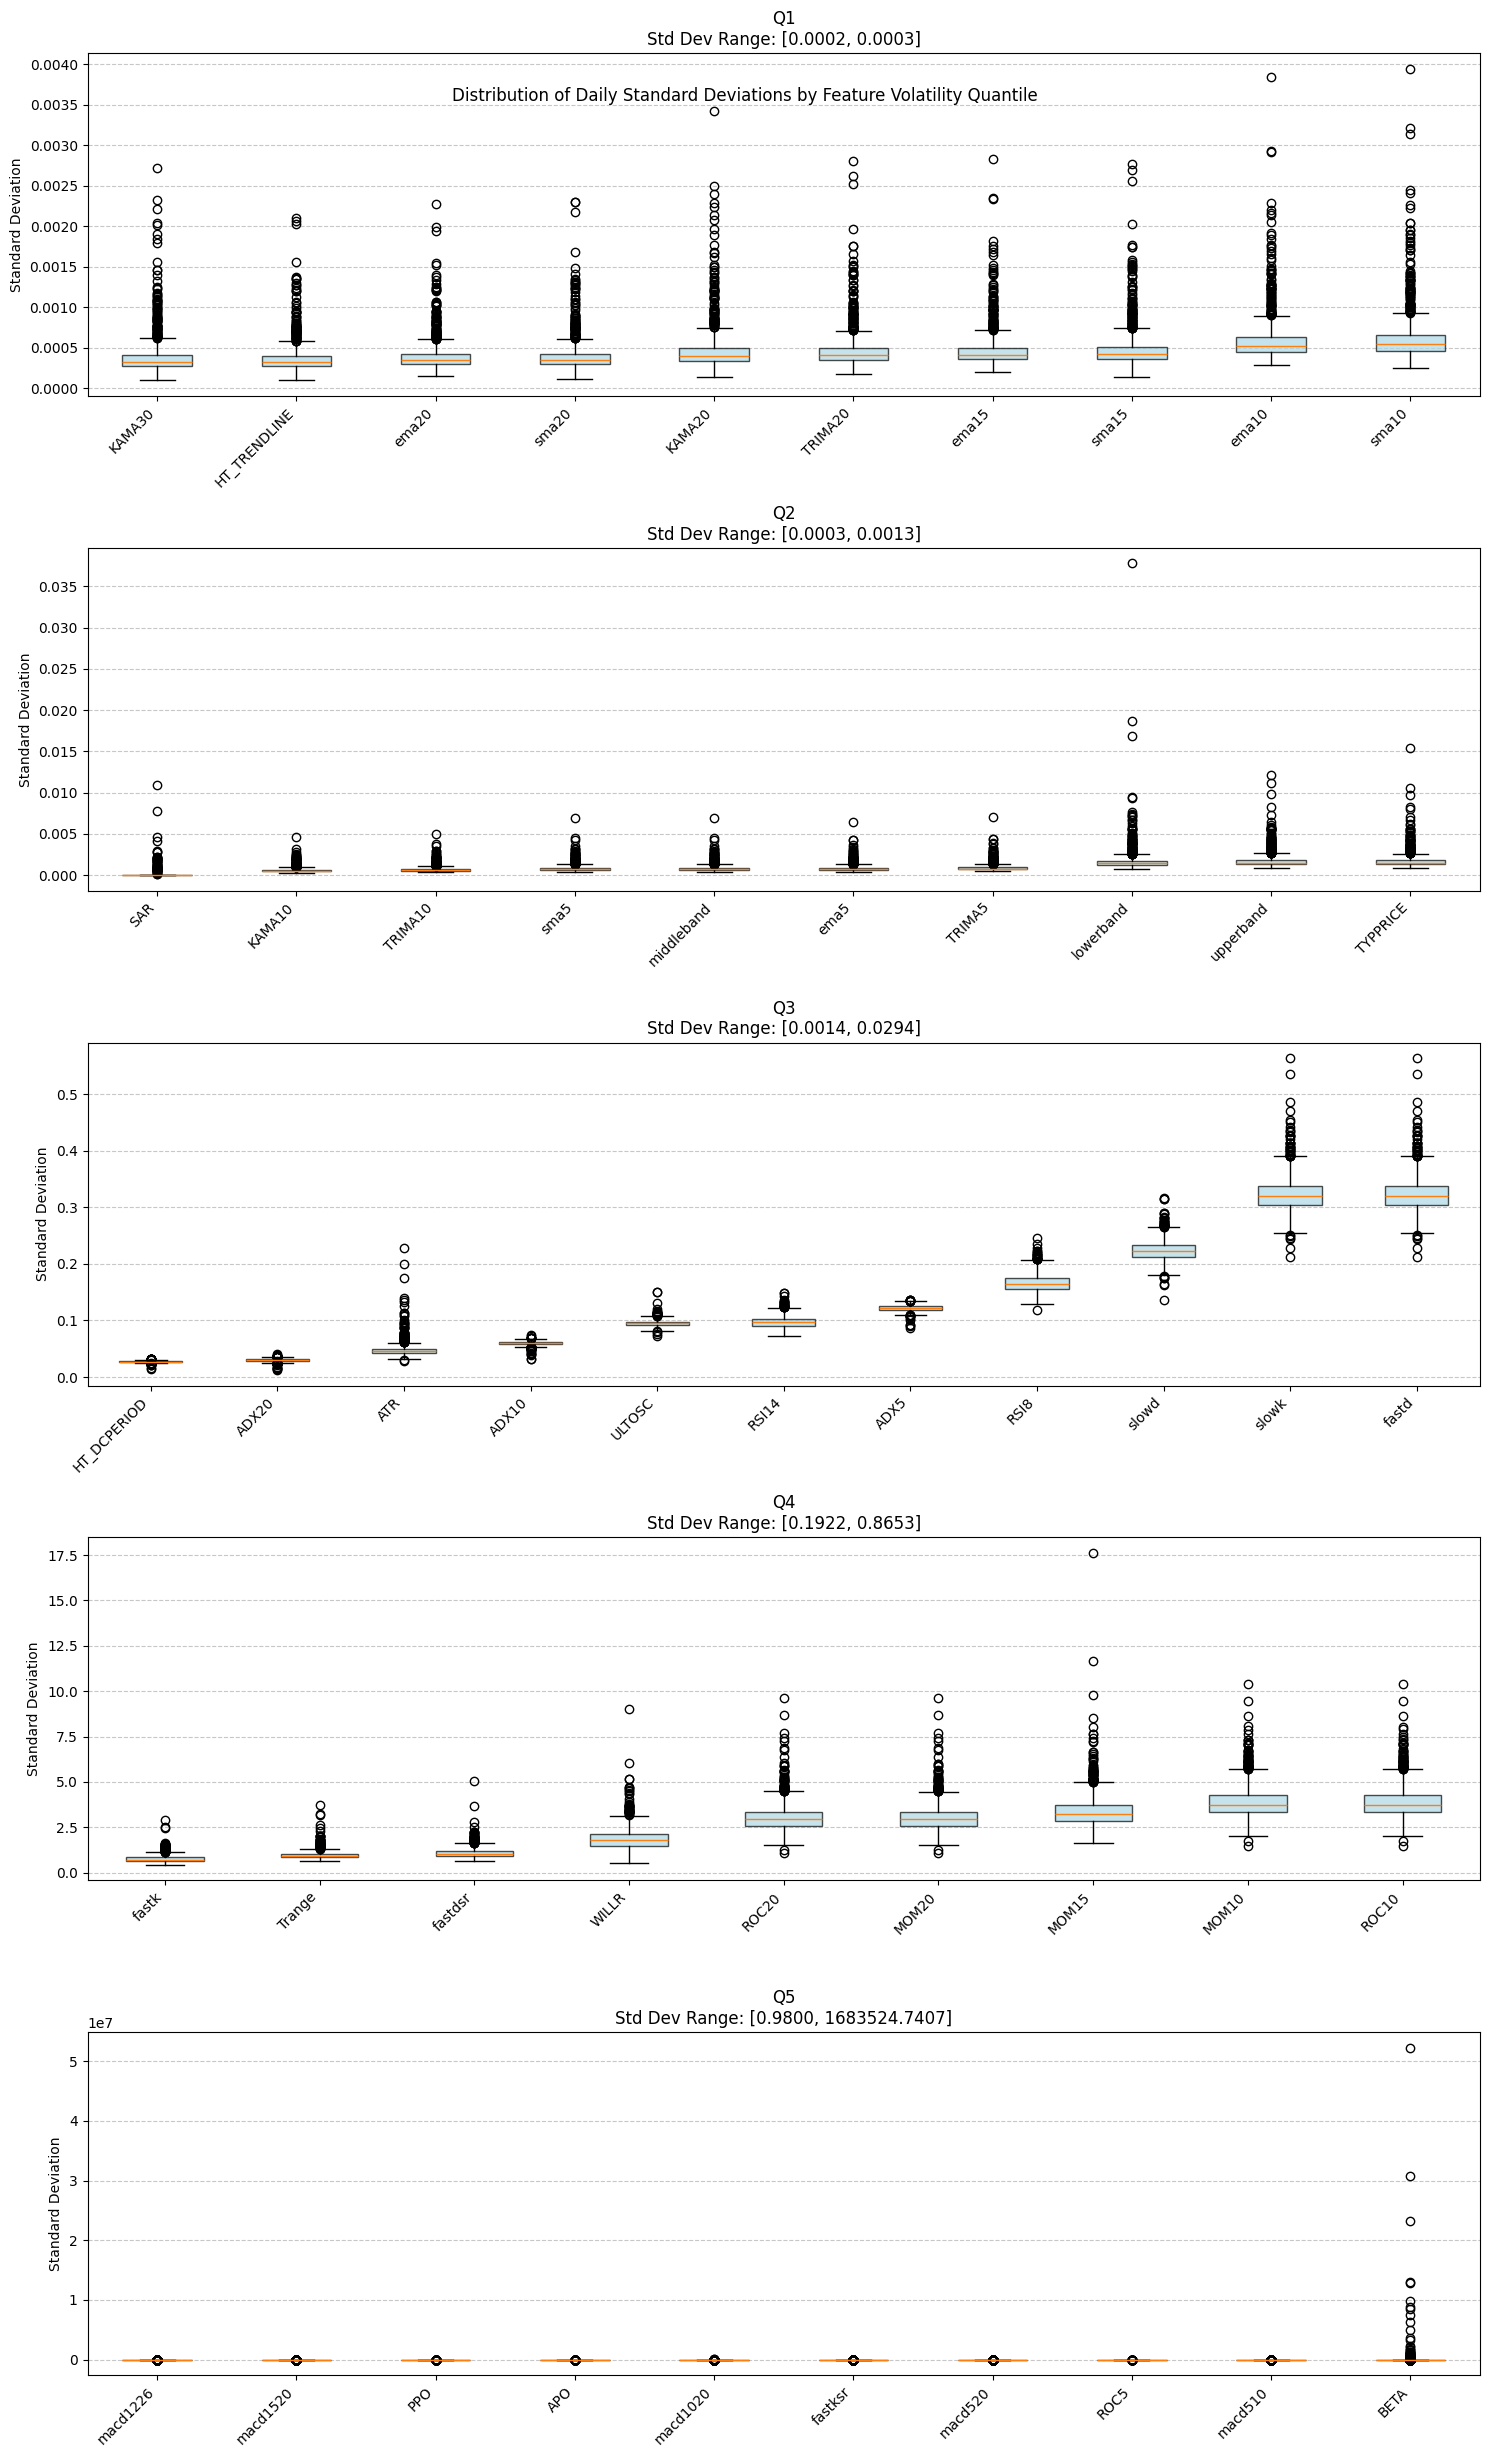


Features by volatility quantile:

Q1 features:
  sma10: 0.0003
  sma15: 0.0002
  sma20: 0.0002
  ema10: 0.0002
  ema15: 0.0002
  ema20: 0.0002
  HT_TRENDLINE: 0.0002
  KAMA20: 0.0002
  KAMA30: 0.0002
  TRIMA20: 0.0002

Q2 features:
  sma5: 0.0004
  ema5: 0.0004
  upperband: 0.0008
  middleband: 0.0004
  lowerband: 0.0013
  KAMA10: 0.0003
  SAR: 0.0004
  TRIMA5: 0.0004
  TRIMA10: 0.0003
  TYPPRICE: 0.0008

Q3 features:
  ADX5: 0.0048
  ADX10: 0.0034
  ADX20: 0.0024
  RSI14: 0.0101
  RSI8: 0.0161
  slowk: 0.0294
  slowd: 0.0171
  fastd: 0.0294
  ULTOSC: 0.0056
  ATR: 0.0112
  HT_DCPERIOD: 0.0014

Q4 features:
  MOM10: 0.8500
  MOM15: 0.8653
  MOM20: 0.7139
  ROC10: 0.8508
  ROC20: 0.7142
  fastk: 0.1922
  fastdsr: 0.2709
  WILLR: 0.5900
  Trange: 0.2091

Q5 features:
  APO: 2.1936
  macd510: 50.3529
  macd520: 53.7459
  macd1020: 416.2876
  macd1520: 34.7879
  macd1226: 18.8686
  ROC5: 0.9800
  PPO: 2.1937
  fastksr: 32.0702
  BETA: 1683524.7407


In [15]:
# Initialize empty dictionary to store daily std values
daily_std_dict = {}
features_drop = ['CCI5','CCI10','CCI15']

for stock in tqdm(cf.top_nifty, total=len(cf.top_nifty)):
    # Get stock data
    df = gp.get_prices(stock)
    df = df[list(cf.factor_cubist.keys())] 
    df = df.drop(columns = features_drop,axis=1)
    
    
    
    # Map values close to zero to exactly zero
    df = df.map(lambda x: 0 if ut.is_null(x) else x)
    
    
    # Calculate percentage change
    df_pct = df.pct_change()
    
    # Replace inf values with NaN and drop them
    df_pct = df_pct.replace([np.inf, -np.inf], np.nan)
    df_pct = df_pct.dropna()

    df_pct['day'] = ut.get_group_key('day', df_pct)
    
    # Calculate daily standard deviation
    daily_std = df_pct.groupby('day').std()
    
    # Store in dictionary
    daily_std_dict[stock] = daily_std

# Create final DataFrame by averaging across all stocks
df_feature = pd.DataFrame()
for stock, std_df in daily_std_dict.items():
    if df_feature.empty:
        df_feature = std_df
    else:
        df_feature = df_feature.add(std_df, fill_value=0)

# Calculate average
df_feature = df_feature / len(daily_std_dict)
# Calculate standard deviation for each feature
feature_stds = df_feature.std()

# Calculate quantiles
quantiles = pd.qcut(feature_stds, q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

# Create dictionary to store features by quantile
quantile_features = {f'Q{i+1}': [] for i in range(5)}
for feature, quantile in zip(feature_stds.index, quantiles):
    quantile_features[quantile].append(feature)



# Create subplots (5 rows, 1 column)
fig, axes = plt.subplots(5, 1, figsize=(15, 25))
fig.suptitle('Distribution of Daily Standard Deviations by Feature Volatility Quantile', y=0.95)

# Create boxplot for each quantile
for i, (quantile, features) in enumerate(quantile_features.items()):
    if features:  # Check if quantile has any features
        # Sort features by median within quantile
        medians = df_feature[features].median()
        sorted_features = medians.sort_values().index
        
        # Create boxplot
        bp = axes[i].boxplot([df_feature[col] for col in sorted_features],
                           tick_labels=sorted_features,
                           patch_artist=True)
        
        # Customize appearance
        axes[i].set_xticklabels(sorted_features, rotation=45, ha='right')
        axes[i].grid(True, axis='y', linestyle='--', alpha=0.7)
        axes[i].set_title(f'{quantile}\nStd Dev Range: [{feature_stds[features].min():.4f}, {feature_stds[features].max():.4f}]')
        
        # Color boxes
        for box in bp['boxes']:
            box.set_facecolor('lightblue')
            box.set_alpha(0.7)
        
        # Add y-label to all subplots
        axes[i].set_ylabel('Standard Deviation')

# Adjust layout with more space between subplots
plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.show()





# Print features in each quantile
print("\nFeatures by volatility quantile:")
for quantile, features in quantile_features.items():
    print(f"\n{quantile} features:")
    for feature in features:
        print(f"  {feature}: {feature_stds[feature]:.4f}")

It appears that most of the features do not exhibit significant intraday movement, except for **CCI5**, **CCI10**, and **CCI15**.

Therefore, it is reasonable to convert the stock dataframe to a daily frequency, as the majority of the features remain relatively stable throughout the trading day.

Henceforth, we will consider **CCI5**, **CCI10**, and **CCI15** as *risky features*. We will retain them temporarily to assess their behavior at a daily frequency.

We will retain only the timestamp of **09:55:00** for each day. If this timestamp is missing on a particular day, we will utilize the closest available timestamp.

I will add the following variables to `config_freq`:

- `risky_features = ['CCI5', 'CCI10', 'CCI15']`
- `config_freq_execution = {'freq': '1d', 'timestamps': ['09:55:00']}`

100%|██████████| 39/39 [00:11<00:00,  3.53it/s]


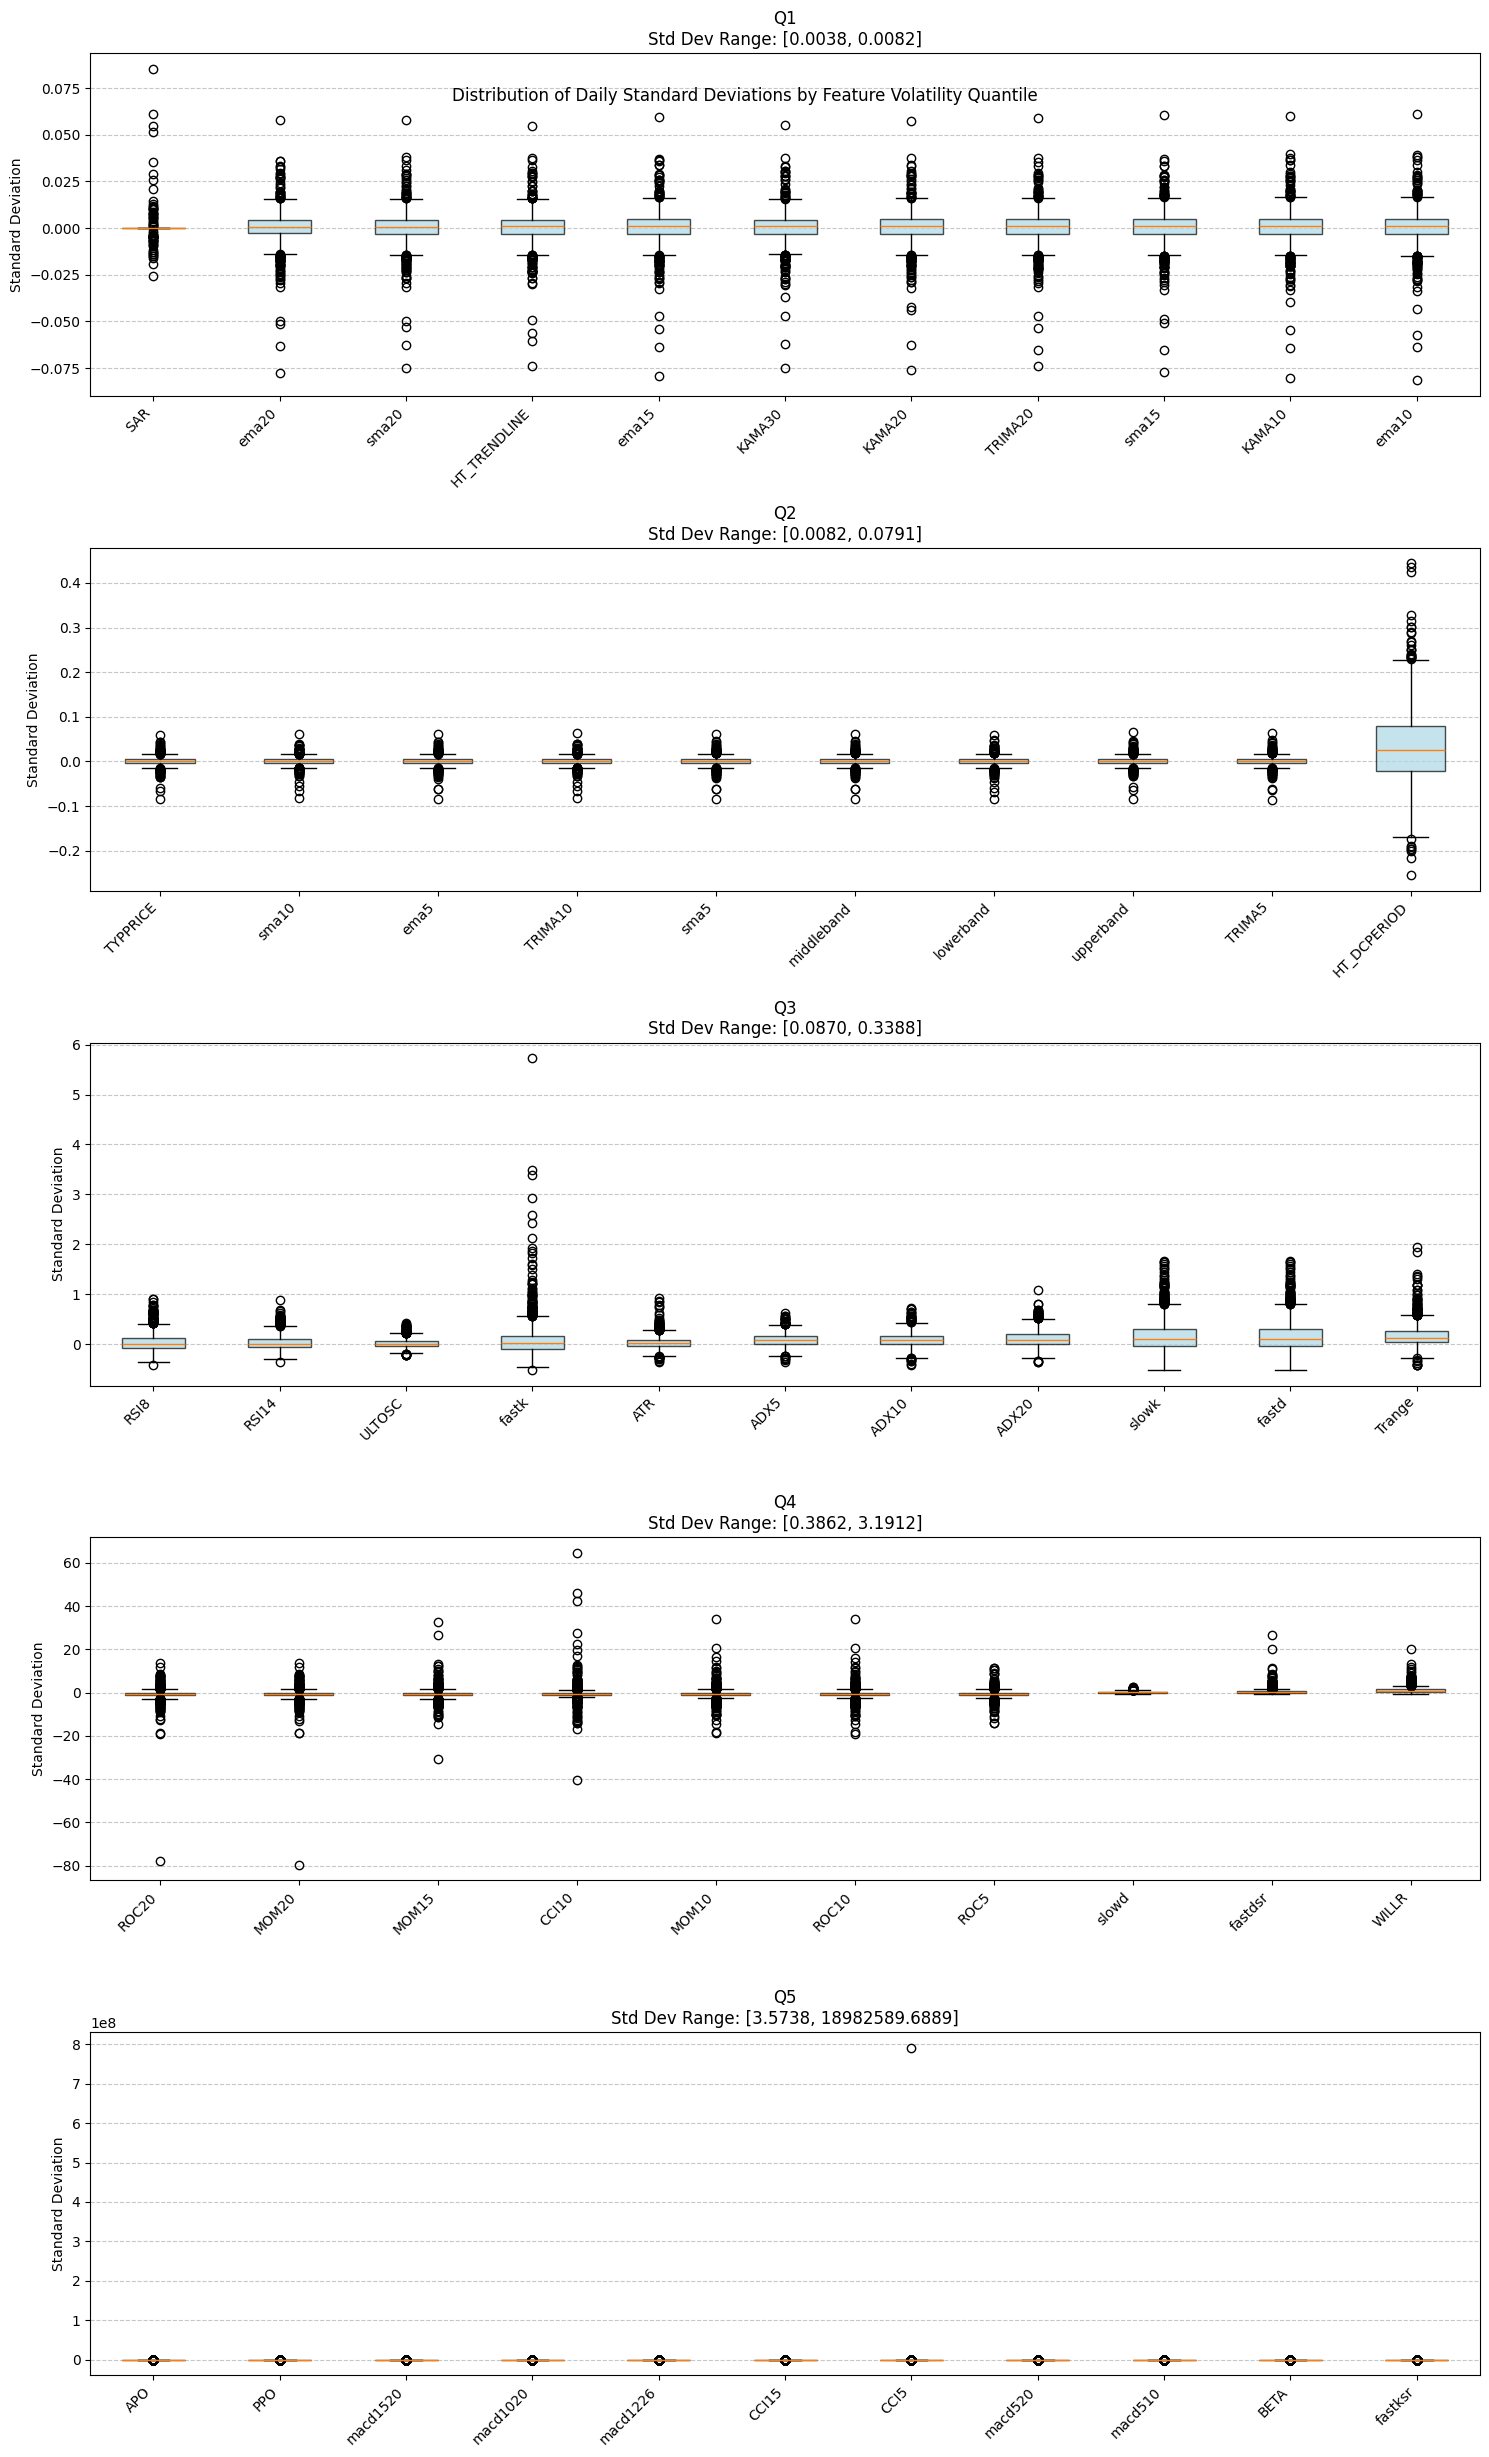


Features by volatility quantile:

Q1 features:
  sma15: 0.0080
  sma20: 0.0079
  ema10: 0.0082
  ema15: 0.0080
  ema20: 0.0078
  HT_TRENDLINE: 0.0078
  KAMA10: 0.0081
  KAMA20: 0.0078
  KAMA30: 0.0077
  SAR: 0.0038
  TRIMA20: 0.0079

Q2 features:
  sma5: 0.0085
  sma10: 0.0082
  ema5: 0.0084
  upperband: 0.0083
  middleband: 0.0085
  lowerband: 0.0087
  TRIMA5: 0.0085
  TRIMA10: 0.0082
  TYPPRICE: 0.0085
  HT_DCPERIOD: 0.0791

Q3 features:
  ADX5: 0.1227
  ADX10: 0.1450
  ADX20: 0.1638
  RSI14: 0.1482
  RSI8: 0.1792
  slowk: 0.2980
  fastk: 0.3388
  fastd: 0.2980
  ULTOSC: 0.0870
  ATR: 0.1229
  Trange: 0.2142

Q4 features:
  CCI10: 3.1912
  MOM10: 2.1527
  MOM15: 2.2005
  MOM20: 2.6057
  ROC5: 1.5669
  ROC10: 2.1441
  ROC20: 2.5753
  slowd: 0.3862
  fastdsr: 1.2500
  WILLR: 1.4220

Q5 features:
  APO: 9.5137
  CCI5: 18982589.6889
  CCI15: 3.5738
  macd510: 15.8416
  macd520: 35.0569
  macd1020: 35.2694
  macd1520: 64.3641
  macd1226: 28.3368
  PPO: 9.4793
  fastksr: 5.4230
  BETA: 11

In [4]:
# Initialize empty dictionary to store daily std values
import matplotlib.pyplot as plt 
daily_pct_dict = {}

for stock in tqdm(cf.top_nifty, total=len(cf.top_nifty)):
    # Get stock data
    df = gp.get_prices(stock) 
    df = df[list(cf.factor_cubist.keys())]
    df = gd.convert_freq(df,**cf.config_freq_execution)
    # Map values close to zero to exactly zero
    df = df.map(lambda x: 0 if ut.is_null(x) else x)
    
    
    # Calculate percentage change
    df_pct = df.pct_change()
    # Replace inf values with NaN and drop them
    df_pct = df_pct.replace([np.inf, -np.inf], np.nan)
    df_pct = df_pct.dropna()
    
    # Store in dictionary
    daily_pct_dict[stock] = df_pct

# Create final DataFrame by averaging across all stocks
df_feature = pd.DataFrame()
for stock, pct_df in daily_pct_dict.items():
    if df_feature.empty:
        df_feature = pct_df
    else:
        df_feature = df_feature.add(pct_df, fill_value=0)

# Calculate average
df_feature = df_feature / len(daily_pct_dict)
# Calculate standard deviation for each feature
feature_stds = df_feature.std()

# Calculate quantiles
quantiles = pd.qcut(feature_stds, q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

# Create dictionary to store features by quantile
quantile_features = {f'Q{i+1}': [] for i in range(5)}
for feature, quantile in zip(feature_stds.index, quantiles):
    quantile_features[quantile].append(feature)



# Create subplots (5 rows, 1 column)
fig, axes = plt.subplots(5, 1, figsize=(15, 25))
fig.suptitle('Distribution of Daily Standard Deviations by Feature Volatility Quantile', y=0.95)

# Create boxplot for each quantile
for i, (quantile, features) in enumerate(quantile_features.items()):
    if features:  # Check if quantile has any features
        # Sort features by median within quantile
        medians = df_feature[features].median()
        sorted_features = medians.sort_values().index
        
        # Create boxplot
        bp = axes[i].boxplot([df_feature[col] for col in sorted_features],
                           tick_labels=sorted_features,
                           patch_artist=True)
        
        # Customize appearance
        axes[i].set_xticklabels(sorted_features, rotation=45, ha='right')
        axes[i].grid(True, axis='y', linestyle='--', alpha=0.7)
        axes[i].set_title(f'{quantile}\nStd Dev Range: [{feature_stds[features].min():.4f}, {feature_stds[features].max():.4f}]')
        
        # Color boxes
        for box in bp['boxes']:
            box.set_facecolor('lightblue')
            box.set_alpha(0.7)
        
        # Add y-label to all subplots
        axes[i].set_ylabel('Standard Deviation')

# Adjust layout with more space between subplots
plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.show()





# Print features in each quantile
print("\nFeatures by volatility quantile:")
for quantile, features in quantile_features.items():
    print(f"\n{quantile} features:")
    for feature in features:
        print(f"  {feature}: {feature_stds[feature]:.4f}")

        

100%|██████████| 39/39 [00:12<00:00,  3.22it/s]


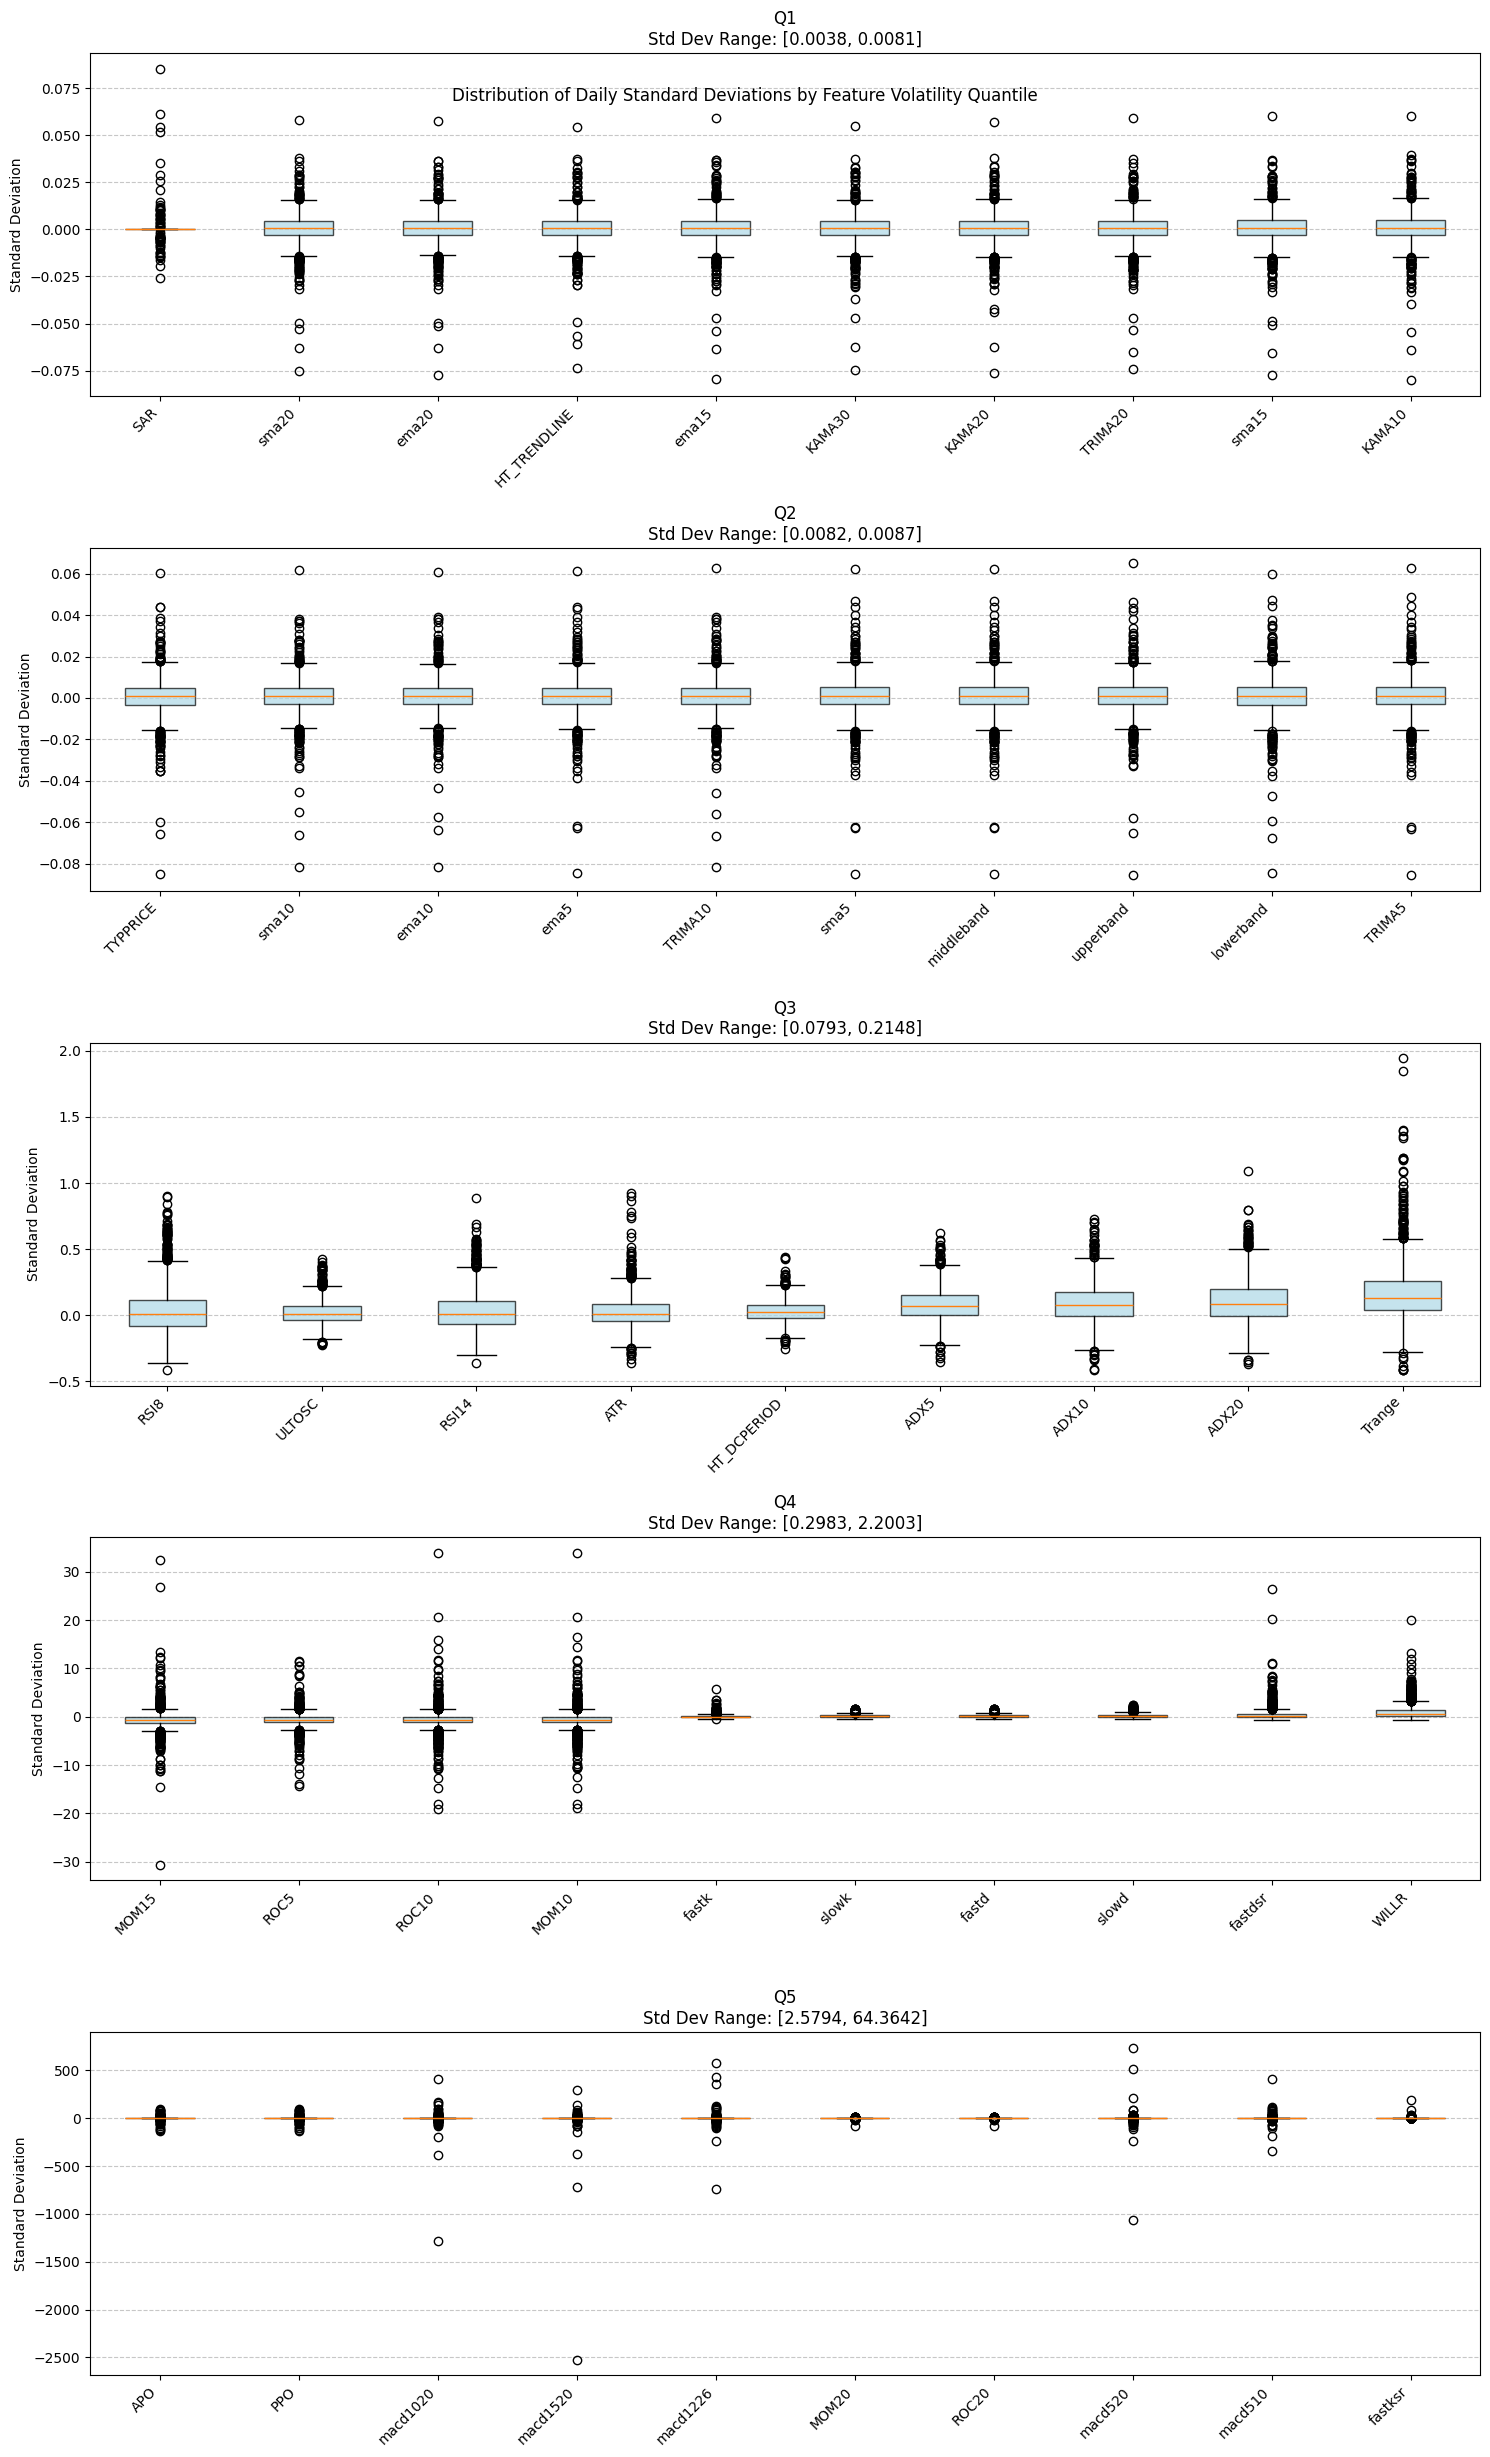


Features by volatility quantile:

Q1 features:
  sma15: 0.0080
  sma20: 0.0079
  ema15: 0.0080
  ema20: 0.0079
  HT_TRENDLINE: 0.0078
  KAMA10: 0.0081
  KAMA20: 0.0078
  KAMA30: 0.0077
  SAR: 0.0038
  TRIMA20: 0.0079

Q2 features:
  sma5: 0.0085
  sma10: 0.0082
  ema5: 0.0084
  ema10: 0.0082
  upperband: 0.0083
  middleband: 0.0085
  lowerband: 0.0087
  TRIMA5: 0.0085
  TRIMA10: 0.0083
  TYPPRICE: 0.0085

Q3 features:
  ADX5: 0.1232
  ADX10: 0.1455
  ADX20: 0.1642
  RSI14: 0.1484
  RSI8: 0.1794
  ULTOSC: 0.0871
  ATR: 0.1236
  Trange: 0.2148
  HT_DCPERIOD: 0.0793

Q4 features:
  MOM10: 2.1724
  MOM15: 2.2003
  ROC5: 1.5737
  ROC10: 2.1643
  slowk: 0.2983
  slowd: 0.3867
  fastk: 0.3394
  fastd: 0.2983
  fastdsr: 1.2504
  WILLR: 1.4235

Q5 features:
  APO: 9.5586
  macd510: 15.8516
  macd520: 35.0564
  macd1020: 35.2692
  macd1520: 64.3642
  macd1226: 28.3371
  MOM20: 2.6097
  ROC20: 2.5794
  PPO: 9.5240
  fastksr: 5.4231


In [5]:
# Initialize empty dictionary to store daily std values
import matplotlib.pyplot as plt 
daily_pct_dict = {}

for stock in tqdm(cf.top_nifty, total=len(cf.top_nifty)):
    # Get stock data
    df = gp.get_prices(stock) 
    df = df[list(cf.factor_cubist.keys())]
    df = gd.convert_freq(df,**cf.config_freq_execution)
    df = df.drop(columns = cf.risky_features,axis=1)
    # Map values close to zero to exactly zero
    df = df.map(lambda x: 0 if ut.is_null(x) else x)
    
    
    # Calculate percentage change
    df_pct = df.pct_change()
    # Replace inf values with NaN and drop them
    df_pct = df_pct.replace([np.inf, -np.inf], np.nan)
    df_pct = df_pct.dropna()
    
    # Store in dictionary
    daily_pct_dict[stock] = df_pct

# Create final DataFrame by averaging across all stocks
df_feature = pd.DataFrame()
for stock, pct_df in daily_pct_dict.items():
    if df_feature.empty:
        df_feature = pct_df
    else:
        df_feature = df_feature.add(pct_df, fill_value=0)

# Calculate average
df_feature = df_feature / len(daily_pct_dict)
# Calculate standard deviation for each feature
feature_stds = df_feature.std()

# Calculate quantiles
quantiles = pd.qcut(feature_stds, q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])

# Create dictionary to store features by quantile
quantile_features = {f'Q{i+1}': [] for i in range(5)}
for feature, quantile in zip(feature_stds.index, quantiles):
    quantile_features[quantile].append(feature)



# Create subplots (5 rows, 1 column)
fig, axes = plt.subplots(5, 1, figsize=(15, 25))
fig.suptitle('Distribution of Daily Standard Deviations by Feature Volatility Quantile', y=0.95)

# Create boxplot for each quantile
for i, (quantile, features) in enumerate(quantile_features.items()):
    if features:  # Check if quantile has any features
        # Sort features by median within quantile
        medians = df_feature[features].median()
        sorted_features = medians.sort_values().index
        
        # Create boxplot
        bp = axes[i].boxplot([df_feature[col] for col in sorted_features],
                           tick_labels=sorted_features,
                           patch_artist=True)
        
        # Customize appearance
        axes[i].set_xticklabels(sorted_features, rotation=45, ha='right')
        axes[i].grid(True, axis='y', linestyle='--', alpha=0.7)
        axes[i].set_title(f'{quantile}\nStd Dev Range: [{feature_stds[features].min():.4f}, {feature_stds[features].max():.4f}]')
        
        # Color boxes
        for box in bp['boxes']:
            box.set_facecolor('lightblue')
            box.set_alpha(0.7)
        
        # Add y-label to all subplots
        axes[i].set_ylabel('Standard Deviation')

# Adjust layout with more space between subplots
plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.show()





# Print features in each quantile
print("\nFeatures by volatility quantile:")
for quantile, features in quantile_features.items():
    print(f"\n{quantile} features:")
    for feature in features:
        print(f"  {feature}: {feature_stds[feature]:.4f}")

        

The analysis indicates once again that **CCI5**, **CCI10**, and **CCI15** are among the most volatile features. Additionally, we observe that the **BETA** feature requires careful handling. Applying smoothing techniques during processing may prove beneficial in mitigating its volatility. We will add **BETA** to the list of risky features.


Henceforth, we will retain only features at a daily frequency. Specifically, we will focus on the timestamp of **09:55:00** for each trading day. If this timestamp is missing on a particular day, we will use the closest available timestamp instead.

### 3) Assessment of Stock Correlation within the Selected Universe

In this section, we aim to evaluate the correlation among the selected stocks in our universe. The objectives are twofold:

- **Diversification Potential**: To determine whether there is sufficient dispersion among the selected stocks to achieve a diversified investment portfolio.

- **Market Proxy Identification**: To identify a stock that exhibits a high degree of correlation with the others, which could serve as a proxy for the overall market performance.

In [2]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go


def get_correlation_matrix(products, config_freq):
    """
    Calculate correlation matrix for a list of products at specified frequency.
    
    Parameters:
    - products: list of product names
    - config_freq: dictionary containing:
        - freq: string ('1m' or '1d')
        - timestamps: list of timestamps or None
    
    Returns:
    - DataFrame: Correlation matrix with modified values (negative correlations set to 0)
    """
    # Get prices and calculate returns for all products
    returns_dict = {}
    for product in tqdm(products,total = len(products)):
        # Get price data
        df = gp.get_prices(product)
        
        # Convert to specified frequency
        df = gd.convert_freq(df, **config_freq)
        
        # Calculate returns
        returns_dict[product] = df['close'].pct_change()
    
    # Create returns DataFrame and drop NaN values
    returns_df = pd.DataFrame(returns_dict)
    returns_df = returns_df.dropna()
    
    # Calculate correlation matrix
    corr_matrix = returns_df.corr()
    
    # Set diagonal to NaN
    np.fill_diagonal(corr_matrix.values, np.nan)
    
    # Set negative correlations to 0
    corr_matrix[corr_matrix < 0] = 0
    
    # Flip matrix to get diagonal from upper left to bottom right
    corr_matrix = corr_matrix.iloc[::-1]
    
    # Invert column order
    corr_matrix = corr_matrix[corr_matrix.columns[::-1]]
    
    return corr_matrix


print("\nCorrelation Matrix:")
corr_matrix = get_correlation_matrix(cf.top_nifty,cf.config_freq_execution)
plot.plot_correlation_heatmap(corr_matrix)


Correlation Matrix:


100%|██████████| 39/39 [00:10<00:00,  3.86it/s]


In [3]:
# Calculate metrics for each column and store in dictionary
product_to_metrics = {}
for product in corr_matrix.columns:
    # Get column values
    product_corr = corr_matrix[product]
    # Calculate metrics (excluding NaN values)
    norm1 = product_corr.abs().sum(skipna=True)
    dispersion = product_corr.std(skipna=True)
    # Get non-NaN values for range calculation
    valid_values = product_corr.dropna()
    range_value = 0 if len(valid_values) == 0 else 1/(valid_values.max() - valid_values.min())
    
     
    
    
    # Store all metrics in nested dictionary
    product_to_metrics[product] = {
        'norm1': np.round(norm1,3),
        'dispersion_penalized': 1/(np.round(dispersion,3)),
        'range' : range_value  
        
    }

# Convert to DataFrame for easier viewing
metric_to_weight = {'norm1':2,'dispersion_penalized':1,'range':1} 
product_to_score = ut.sort_polynomial_target(product_to_metrics,metric_to_weight= metric_to_weight)
metrics_score = pd.DataFrame.from_dict(product_to_score, orient='index')
metrics_score.columns = ['score']

metrics_df = pd.DataFrame.from_dict(product_to_metrics, orient='index')

# Sort by score values
metrics_score = metrics_score.sort_values('score', ascending=False)

# Get top 10 products with lowest scores
top_10_products = metrics_score.tail(5).index

# Filter metrics_df to keep only top 10 products
metrics_df = metrics_df.loc[top_10_products]

# Print results
print("Score for top 10 product:")
print(metrics_score.tail(10))
print('Metric for each top product')
print(metrics_df)


Score for top 10 product:
               score
ADANIPORTS  8.665778
SUNPHARMA   8.067165
TITAN       7.891502
HINDUNILVR  7.699476
KOTAKBANK   7.424700
RELIANCE    7.328863
ITC         7.035585
BHARTIARTL  6.672437
TCS         5.904463
AUROPHARMA  5.112056
Metric for each top product
             norm1  dispersion_penalized     range
RELIANCE    11.181             12.500000  3.042401
ITC          9.385             14.084507  2.990025
BHARTIARTL   8.268             14.285714  3.365702
TCS          6.897             17.857143  3.802897
AUROPHARMA   6.839             20.000000  4.366390


With our polynomial objective to maximize the score, we end up with 5 winners. This method is not without flaws, but it allows us to have an idea of which stocks are the most correlated with the others. We want to consider that a stock is most correlated with others if:

- The norm-1 of the correlation vector is high. It's one of the most important metrics, so we will give more weight to it.
- The dispersion of the correlation vector needs to be low.
- The range of the correlation needs to be low.

We could construct an aggregate of the top 5 winners to have a proxy for the market. However, after looking into information about each of these stocks, it seems that it makes sense to take **RELIANCE** as the only proxy for the Indian market. **RELIANCE** represents almost 10% of the NIFTY index.

In [4]:
# Calculate correlation with Reliance for each semester
proxy_market = 'RELIANCE'
correlations = []

# Get proxy market data and calculate returns
proxy_df = gp.get_prices(proxy_market)
proxy_df = proxy_df.map(lambda x: 0 if ut.is_null(x) else x)
proxy_df['semester'] = ut.get_group_key('semester', proxy_df)
proxy_df['returns'] = proxy_df['close'].pct_change()
proxy_df = proxy_df.replace([np.inf, -np.inf], np.nan)
proxy_df = proxy_df.dropna()

for stock in tqdm(cf.top_nifty, total=len(cf.top_nifty)):
    if stock != proxy_market:
        # Get stock data and calculate returns
        stock_df = gp.get_prices(stock)
        stock_df = stock_df.map(lambda x: 0 if ut.is_null(x) else x)
        stock_df['semester'] = ut.get_group_key('semester', stock_df)
        stock_df['returns'] = stock_df['close'].pct_change()
        stock_df = stock_df.replace([np.inf, -np.inf], np.nan)
        stock_df = stock_df.dropna()
        
        # Ensure alignment of indices
        common_idx = stock_df.index.intersection(proxy_df.index)
        stock_df = stock_df.loc[common_idx]
        proxy_aligned = proxy_df.loc[common_idx]
        
        # Calculate correlation for each semester
        for semester in stock_df['semester'].unique():
            semester_stock = stock_df[stock_df['semester'] == semester]['returns']
            semester_proxy = proxy_aligned[proxy_aligned['semester'] == semester]['returns']
            
            if len(semester_stock) > 0 and len(semester_proxy) > 0:
                correlation = semester_stock.corr(semester_proxy)
                correlations.append({
                    'stock': stock,
                    'semester': semester,
                    'correlation': correlation
                })

# Convert to DataFrame
correlation_df = pd.DataFrame(correlations)
print('Correlation between the top_nifty stocks and RELIANCE')
print(correlation_df)

100%|██████████| 39/39 [01:33<00:00,  2.39s/it]

Correlation between the top_nifty stocks and RELIANCE
          stock semester  correlation
0    ADANIPORTS  S1-2015     0.262168
1    ADANIPORTS  S2-2015     0.327054
2    ADANIPORTS  S1-2016     0.320819
3    ADANIPORTS  S2-2016     0.303542
4    ADANIPORTS  S1-2017     0.170179
..          ...      ...          ...
565     YESBANK  S1-2020     0.191386
566     YESBANK  S2-2020     0.030268
567     YESBANK  S1-2021     0.168049
568     YESBANK  S2-2021     0.128917
569     YESBANK  S1-2022     0.216369

[570 rows x 3 columns]


In [5]:
# Create a figure for each semester 
semesters = correlation_df['semester'].unique()
n_quantiles = 5
for semester in semesters:
    # Filter data for this semester
    semester_data = correlation_df[correlation_df['semester'] == semester]
    
    # Create series of volumes for this semester
    correlation_series = semester_data.set_index('stock')['correlation']
    
    # Plot histogram with quantiles
    fig = plot.plot_histogram_quantile(
        series=correlation_series,
        n_quantiles=n_quantiles,
        title=f'Correlation Distribution for {semester}'
    )
    fig.show()